# Bootstraping 

In [11]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Carga de datos

In [44]:
"""
Settings
"""
sns.set_style('darkgrid')

plt.rcParams["font.family"] = "serif"

plt.rcParams["font.size"] = "12"


In [45]:
# set de datos generado
x,y,coef = make_regression(n_samples=5000,n_features=1,n_targets=1,coef=True,noise=5.0,bias=1.0,random_state=42)

### Funciones 

In [17]:
def make_bootstraps(data: np.array, n_bootstraps: int=100) :
    """
    Function to generate bootstrapped samples
    
    Inputs:
        data         -> array of input data
        n_bootstraps -> integer number of bootstraps to produce
        
    Outputs:
        {'boot_n': {'boot': np.array, 'test': np.array}} -> dictionary of dictionaries containing 
                                                            the bootstrap samples & out-of-bag test sets
    """
    
    # initialize output dictionary, unique value count, sample size, & list of indices
    dc       = {}
    n_unival = 0
    sample_size = data.shape[0]
    idx = [i for i in range(sample_size)]
    # loop through the required number of bootstraps
    for b in range(n_bootstraps):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        b_samp = data[sidx,:]
        # compute number of unique values contained in the bootstrap sample
        n_unival += len(set(sidx))
        # obtain out-of-bag samples for the current b
        oob_idx = list(set(idx) - set(sidx))
        t_samp = np.array([])
        if oob_idx:
            t_samp = data[oob_idx,:]
        # store results
        dc['boot_'+str(b)] = {'boot':b_samp,'test':t_samp}
    # state the mean number of unique values in the bootstraps
    print('Mean number of unique values in each bootstrap: {:.2f}'.format(n_unival/n_bootstraps))
    # return the bootstrap results
    return(dc)

In [56]:
def regression(boots: dict):
    """
    Fuction to generate a linear regression over a set of bootstrap samples
    
    Inputs:
        boots -> dict of the bootsstraping sample  {'boot_n': {'boot': np.array, 'test': np.array}}
        
    Output:
        Four-tuple
            (coefs,intrs,maes,mses) -> Four - Tuple containing a np.array with the coefficients, intercepts and error 
                                         metrics of every regression
        
    """
    # initialize storage variables & model
    coefs = np.array([])
    intrs = np.array([])
    maes  = np.array([])
    mses  = np.array([])
    lr    = LinearRegression()
    # loop through each bootstrap sample
    for b in dcBoot:
        # fit a linear regression model to the current sample
        lr.fit(dcBoot[b]['boot'][:,0].reshape(-1, 1),dcBoot[b]['boot'][:,1].reshape(-1, 1))
        # store model parameters
        coefs = np.concatenate((coefs,lr.coef_.flatten()))
        intrs = np.concatenate((intrs,lr.intercept_.flatten()))
        # compute the predictions on the out-of-bag test set & compute metrics
        if dcBoot[b]['test'].size:
            yp  = lr.predict(dcBoot[b]['test'][:,0].reshape(-1, 1))
            mae = mean_absolute_error(dcBoot[b]['test'][:,1],yp)
            mse = mean_squared_error(dcBoot[b]['test'][:,1],yp)   
            # store the error metrics
            maes = np.concatenate((maes,mae.flatten()))
            mses = np.concatenate((mses,mse.flatten()))
    return (coefs, intrs,maes,mses)

### Aplicación

In [58]:

data = np.concatenate((x,y.reshape(-1,1)),axis=1)

dcBoot = make_bootstraps(data)

AxisError: axis 1 is out of bounds for array of dimension 1

In [59]:
(coefs, intrs ,maes,mses) = regression(dcBoot)

### Resultados 

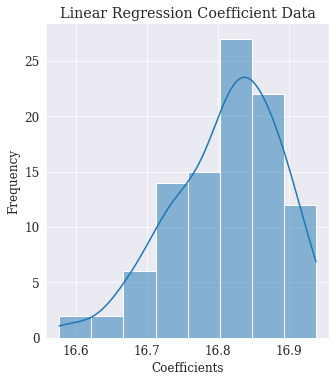

In [60]:
# plot histogram of regression coefficients
sns.displot(coefs, kde=True)
plt.title('Linear Regression Coefficient Data')
plt.xlabel('Coefficients')
plt.ylabel('Frequency')
plt.show()

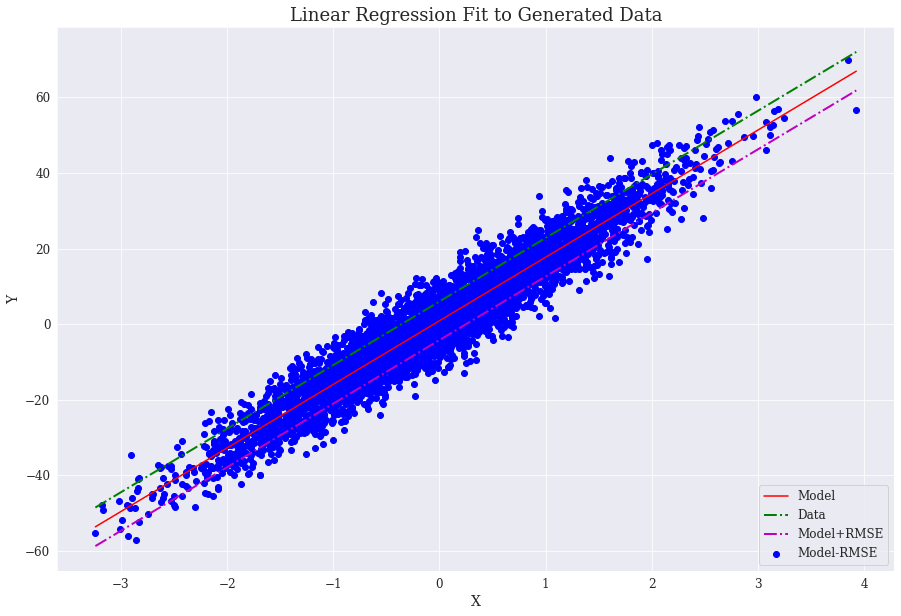

In [61]:
# plot the model against the dataset
x = data[:,0]
y = data[:,1]
xp = np.linspace(min(x),max(x),100)
plt.figure(figsize=(15,10))
plt.plot(xp,np.mean(coefs)*xp+np.mean(intrs),color='r')
plt.scatter(x,y,color='b')
plt.plot(xp,np.mean(coefs)*xp+np.mean(intrs)+np.mean(np.sqrt(mses)),'-.g',linewidth=2)
plt.plot(xp,np.mean(coefs)*xp+np.mean(intrs)-np.mean(np.sqrt(mses)),'-.m',linewidth=2)
plt.title('Linear Regression Fit to Generated Data', fontsize=18)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend(['Model','Data','Model+RMSE','Model-RMSE'],loc='lower right')
plt.show()